In [2]:
import torch
import random
import numpy as np
import pandas as pd
from glob import glob
import os
import cv2
import gc
import warnings

from sklearn.model_selection import KFold
from tqdm.auto import tqdm
import torchvision.models as models
from matplotlib import pyplot as plt
from transformers import get_cosine_schedule_with_warmup

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

warnings.filterwarnings('ignore') #경고 무시

## 데이터 로드

In [3]:
os.chdir("C:/deep/Animals-10-classification/")

classes = ["butterfly", "cat", "chicken", "cow", "dog", "elephant", "horse", "sheep", "spider", "squirrel"]

In [4]:
train_img = []
test_img = []

In [5]:
for i in classes:
    train_jpg = sorted(glob('train_img/' + f'{i}' + '/' + f'{i}_*.jpg'))
    train_img.extend(train_jpg)

    test_jpg = sorted(glob('test_img/' + f'{i}' + '/' + f'{i}_*.jpg'))
    test_img.extend(test_jpg)

In [6]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (256, 256))
    gc.collect()
    torch.cuda.empty_cache()
    return img

train_imgs = [img_load(m) for m in tqdm(train_img)]
test_imgs = [img_load(n) for n in tqdm(test_img)]

  0%|          | 0/20938 [00:00<?, ?it/s]

  0%|          | 0/5241 [00:00<?, ?it/s]

In [7]:
def files_count(directory_path):
    directory = os.listdir(directory_path)
    return len(directory)

# train data label 부여
train_labels = []
for i in classes:
    length = files_count('train_img/' + f'{i}')
    train_labels.extend([classes.index(f'{i}')] * length)

In [8]:
# df_train = pd.DataFrame()
# df_train['img'] = train_imgs
# df_train['class'] = train_labels

In [9]:
# test data label 부여
test_labels = []
for i in classes:
    length = files_count('test_img/' + f'{i}')
    test_labels.extend([classes.index(f'{i}')] * length)

In [10]:
# df_test = pd.DataFrame()
# df_test['img'] = test_imgs
# df_test['class'] = label
#
# df_train.shape, df_test.shape

# Hyper Parameter

In [66]:
HYP = {
    'EPOCHS' : 3,
    'BATCH_SIZE' : 32,
    'LEARNING_RATE' : 3e-4,
    'log' : True,
    'SEED': 41,
    'IMG_SIZE': 256
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(HYP['SEED'])

## Augmentation

In [12]:
from albumentations.augmentations.transforms import Normalize
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
        A.RandomGamma(gamma_limit=(90, 110)),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10),
        A.Transpose(),
        A.RandomRotate90(),
        A.OneOf([A.NoOp(), A.MultiplicativeNoise(), A.GaussNoise(), A.ISONoise()]),
        A.OneOf(
            [
                A.NoOp(p=0.8),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10),
                A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10)
            ],
            p=0.2,
        ),
        A.OneOf([A.ElasticTransform(), A.GridDistortion(), A.NoOp()]),
        A.Resize(HYP['IMG_SIZE'], HYP['IMG_SIZE']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Resnet 참고
        ToTensorV2(),
])

test_transform = A.Compose([
        A.Resize(HYP['IMG_SIZE'], HYP['IMG_SIZE']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Resnet 참고
        ToTensorV2()
])

In [13]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score
import time

class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode=='train':
            img = train_transform(image=img)

        if self.mode=='test':
            img = test_transform(image=img)

        label = self.labels[idx]
        return img, label

## DataLoader

In [14]:
#CustomDataset class를 통하여 train dataset생성
# train_dataset = Custom_dataset(np.array(train_imgs), np.array(train_labels), mode='train')
#만든 train dataset를 DataLoader에 넣어 batch 만들기
# train_loader = DataLoader(train_dataset, batch_size = HYP["BATCH_SIZE"], shuffle=True, num_workers=0)

#CustomDataset class를 통하여 test dataset생성
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
#만든 test dataset를 DataLoader에 넣어 batch 만들기
test_loader = DataLoader(test_dataset, batch_size = HYP["BATCH_SIZE"], shuffle=False, num_workers=0)

## Model Architecture

In [15]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        total_params+=param
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [56]:
class Resnet50(torch.nn.Module):
    def __init__(self):
        super(Resnet50, self).__init__()
        self.model = models.resnet50(pretrained=True)

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)

        count_parameters(self.model)
    def forward(self, inputs):
        output = self.model(inputs)
        return output

class Network_b3(nn.Module):
    def __init__(self):
        super(Network_b3, self).__init__()
        self.model = models.efficientnet_b3(pretrained=True)

        # num_ftrs = self.model.fc.in_features
        # self.model.fc = nn.Linear(num_ftrs, 10)

        count_parameters(self.model)
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## Loss

In [57]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

## Train

In [58]:
# Resnet = Resnet50().to(device)
#
# optimizer = torch.optim.Adam(Resnet.parameters(), lr=HYP['LEARNING_RATE'])
# criterion = nn.CrossEntropyLoss()
# scaler = torch.cuda.amp.GradScaler()
#
# path = './weights/'
# if not os.path.isdir(path):
#     os.mkdir(path)
#
# epochs = HYP['EPOCHS']
#
# for epoch in range(epochs):
#     start=time.time()
#     train_loss = 0
#     train_pred=[]
#     train_y=[]
#     Resnet.train()
#     for batch in (train_loader):
#         optimizer.zero_grad()
#         x = torch.tensor(batch[0]['image'], dtype=torch.float32, device=device)
#         y = torch.tensor(batch[1], dtype=torch.long, device=device)
#
#         pred = Resnet(x)
#         loss = criterion(pred, y)
#
#
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
#
#         train_loss += loss.item()/len(train_loader)
#         train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
#         train_y += y.detach().cpu().numpy().tolist()
#
#     train_f1 = score_function(train_y, train_pred)
#
#     TIME = time.time() - start
#     print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
#     print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')
#
#     # 모델 저장
#     torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': Resnet.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 "scaler": scaler.state_dict(),
#                 'loss': loss,
#                 }, f"{path}/Resnet.pt")

In [59]:
path = './saved/'
if not os.path.isdir(path):
    os.mkdir(path)

def train(model, optimizer, train_loader, vali_loader, scheduler, device, fold):

    # Loss Function
    criterion = nn.CrossEntropyLoss().to(device)
    scaler = torch.cuda.amp.GradScaler()
    best_f1 = 0

    for epoch in range(1,HYP["EPOCHS"]+1):
        start=time.time()
        model.train()
        train_loss = 0
        train_pred=[]
        train_label=[]

        for batch in (train_loader):
            optimizer.zero_grad()
            img = torch.tensor(batch[0]['image'], dtype=torch.float32, device=device)
            label = torch.tensor(batch[1], dtype=torch.long, device=device)

            with torch.cuda.amp.autocast():
                pred = model(img)

            # Calc loss
            loss = criterion(pred, label)

            # backpropagation
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()/len(train_loader)
            train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
            train_label += label.detach().cpu().numpy().tolist()

        train_f1 = score_function(train_label, train_pred)

        TIME = time.time() - start

        epochs = HYP["EPOCHS"]
        print(f'epoch : {epoch}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
        print(f'TRAIN_loss : {train_loss:.5f}    train_f1 : {train_f1:.5f}')

        if scheduler is not None:
            scheduler.step()

        # Evaluation Validation set
        vali_f1 = validation(model, vali_loader, criterion, device)

        print(f'Epoch [{epoch}] Train f1_score : [{np.mean(train_f1):.5f}] \
        Validation f1_score : [{vali_f1:.5f}]')

        # Model Saved
        if best_f1 < vali_f1:
            best_f1 = vali_f1
            torch.save(model.state_dict(), './saved/res50_fold{}.pth'.format(fold))
            print('Model Saved.')

    plt.plot(train_f1, label = 'trn')
    plt.plot(vali_f1, label = 'vali')
    plt.legend(loc='upper right')
    plt.show()

In [60]:
def validation(model, vali_loader, criterion, device):
    model.eval() # Evaluation

    vali_loss = 0
    vali_pred = []
    vali_label = []
    with torch.no_grad():
        for batch in (vali_loader):
            img = torch.tensor(batch[0]['image'], dtype=torch.float32, device=device)
            label = torch.tensor(batch[1], dtype=torch.long, device=device)

            with torch.cuda.amp.autocast():
                pred = model(img)

            loss = criterion(pred, label)

            vali_loss += loss.item()/len(vali_loader)
            vali_pred += pred.argmax(1).detach().cpu().numpy().tolist()
            vali_label += label.detach().cpu().numpy().tolist()

            # pred = pred.squeeze(1).detach().cpu()
            # label = label.detach().cpu().numpy().tolist()
            # vali_label.extend(label.tolist())
            # vali_pred.extend(pred.tolist())


        vali_f1 = score_function(vali_label, vali_pred)


    # if HYP['log']:
    #     vali_nmae_loss = NMAE(np.expm1(np.array(label_true)), np.expm1(np.array(model_pred)))
    #     diff = np.abs(np.expm1(np.array(label_true)) - np.expm1(np.array(model_pred)))
    # else:
    #     vali_nmae_loss = NMAE(np.array(label_true), np.array(model_pred))
    #     diff = (np.array(label_true) - np.array(model_pred))


    # if best_f1 > vali_f1:
    #     plt.figure(figsize=(30,2))
    #     plt.plot(best_f1, vali_f1)
    #     plt.axhline(y=0.1*100, color='black')
    #     plt.axhline(y=0.2*100, color='black')
    #     plt.axhline(y=0.3*100, color='black')
    #     plt.axhline(y=0.4*100, color='black')
    #     plt.axhline(y=0.5*100, color='black')
    #     # if HYP['log']:
    #     #     plt.axhline(y=np.expm1(np.mean(label_true)), color='red')
    #     # else:
    #     #     plt.axhline(y=np.mean(label_true), color='red')
    #     # ax_twin = plt.twinx()
    #     # if HYP['log']:
    #     #     ax_twin.plot(np.expm1(np.array(label_true)), alpha=0.5)
    #     # else:
    #     #     ax_twin.plot(np.array(label_true), alpha=0.5)
    # plt.show()
    return vali_f1

################################################################################
fold: 0
Total Trainable Params: 12233232
total_steps:  15703
warmup_steps:  1570
epoch : 2/30    time : 561s/15707s
TRAIN_loss : 8.32907    train_f1 : 0.00002
Epoch [1] Train f1_score : [0.00002]         Validation f1_score : [0.00000]
epoch : 3/30    time : 557s/15046s
TRAIN_loss : 8.22939    train_f1 : 0.00003
Epoch [2] Train f1_score : [0.00003]         Validation f1_score : [0.00000]
epoch : 4/30    time : 558s/14504s
TRAIN_loss : 7.97236    train_f1 : 0.00003
Epoch [3] Train f1_score : [0.00003]         Validation f1_score : [0.00000]
epoch : 5/30    time : 560s/14011s
TRAIN_loss : 7.54943    train_f1 : 0.00008
Epoch [4] Train f1_score : [0.00008]         Validation f1_score : [0.00000]
epoch : 6/30    time : 555s/13309s
TRAIN_loss : 7.03536    train_f1 : 0.00009
Epoch [5] Train f1_score : [0.00009]         Validation f1_score : [0.00000]
epoch : 7/30    time : 560s/12889s
TRAIN_loss : 6.37938    trai

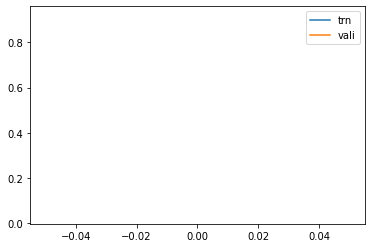

################################################################################
fold: 1
Total Trainable Params: 12233232
total_steps:  15703
warmup_steps:  1570
epoch : 2/30    time : 540s/15127s
TRAIN_loss : 8.37737    train_f1 : 0.00003
Epoch [1] Train f1_score : [0.00003]         Validation f1_score : [0.00000]
epoch : 3/30    time : 542s/14636s
TRAIN_loss : 8.29802    train_f1 : 0.00002
Epoch [2] Train f1_score : [0.00002]         Validation f1_score : [0.00000]
epoch : 4/30    time : 546s/14208s
TRAIN_loss : 8.03950    train_f1 : 0.00003
Epoch [3] Train f1_score : [0.00003]         Validation f1_score : [0.00000]
epoch : 5/30    time : 540s/13512s
TRAIN_loss : 7.62914    train_f1 : 0.00004
Epoch [4] Train f1_score : [0.00004]         Validation f1_score : [0.00000]
epoch : 6/30    time : 547s/13137s
TRAIN_loss : 7.16351    train_f1 : 0.00007
Epoch [5] Train f1_score : [0.00007]         Validation f1_score : [0.00000]
epoch : 7/30    time : 543s/12495s
TRAIN_loss : 6.56563    trai

KeyboardInterrupt: 

In [61]:
list_idx = list(np.arange(0,len(train_imgs)))

kf = KFold(n_splits=5)
for fold, (train_idx, valid_idx) in enumerate(kf.split(list_idx)):
    print("#"*80)
    print("fold: {}".format(fold))
    train_img_list = [train_imgs[i] for i in train_idx]
    train_label = [train_labels[i] for i in train_idx]

    vali_img_list = [train_imgs[i] for i in valid_idx]
    vali_label = [train_labels[i] for i in valid_idx]

    # Get Dataloader
    train_dataset = Custom_dataset(train_img_list, train_label, mode='train',)
    train_loader = DataLoader(train_dataset, batch_size = HYP['BATCH_SIZE'], shuffle=False, num_workers=0)

    vali_dataset = Custom_dataset(vali_img_list, vali_label, mode='test')
    vali_loader = DataLoader(vali_dataset, batch_size = HYP['BATCH_SIZE'], shuffle=False, num_workers=0)

    model = Network_b3().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=HYP['LEARNING_RATE'])

    total_steps = int(len(train_dataset)*HYP['EPOCHS']/(HYP['BATCH_SIZE']))
    warmup_ratio = 0.1
    warmup_steps = int(total_steps * warmup_ratio)
    print('total_steps: ', total_steps)
    print('warmup_steps: ', warmup_steps)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    train(model, optimizer, train_loader, vali_loader, scheduler, device, fold)

In [ ]:
def predict(model, test_loader, device):
    model.eval()
    test_loss = []
    model_pred = []
    test_pred=[]
    test_label=[]

    with torch.no_grad():
        for batch in (test_loader):
            img = torch.tensor(batch[0]['image'], dtype=torch.float32, device=device)
            label = torch.tensor(batch[1], dtype=torch.long, device=device)

            pred = model(img)
            pred = pred.squeeze(1).detach().cpu()
            # loss = criterion(pred, label)
            #
            # test_loss.append(loss.item())

            pred = pred.squeeze(1).detach().cpu()
            label = label.detach().cpu()

            test_label.extend(label.tolist())
            test_pred.extend(pred.tolist())

            model_pred.extend(pred.tolist())

        test_f1 = score_function(test_label, test_pred)
        print(f'test_f1 [{test_f1}])

    return model_pred

checkpoint = torch.load('./saved/res50_fold{}.pth'.format(fold))
model = Network_b3().to(device)
model.load_state_dict(checkpoint)

preds = predict(model, test_loader, device)